# Demonstration notebook: accessing PGV data and creating a ROM

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from sklearn.model_selection import train_test_split

plt.rcParams['font.size'] = 14

In this notebook, we demonstrate the method of usingthe iPOD (interpolated
proper orthogonal decomposition) technique to create a reduced order model.
This demonstration will use the layer-over-halfpsace (LOH) forward
model and the radial basis function (RBF) interpolator.
We first read in the data stored as an HDF5 file using the h5py library.

In [2]:
f = h5py.File('pgv_data/loh.hdf5', 'r')

We then look at an example of PGV map contained in this dataset using the `data` key. The data are stored
as vectors, so we must reshape to a 2D matrix in order to plot the data.

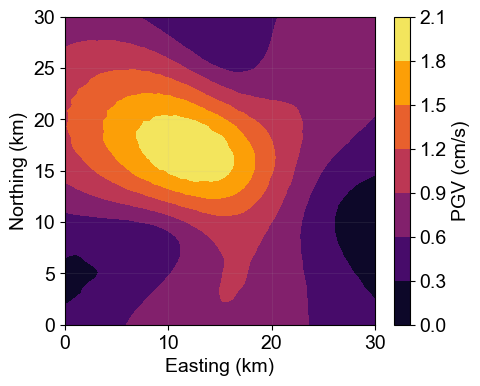

In [3]:
x = np.linspace(0, 30, 60)
y = np.linspace(0, 30, 60)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(5, 4))
plt.contourf(X, Y, 100 * f['data'][1].reshape(60, 60).T, cmap='inferno')
plt.xlabel('Easting (km)')
plt.ylabel('Northing (km)')
plt.colorbar(label='PGV (cm/s)')
plt.show()

We can also see the earthquake source parameters 
(hypocentral depth, strike, dip, and rake) for this PGV map using the `params` key:

In [4]:
print(f['params'][1])

[ 12.78419204 111.25159172  86.9734588  122.60283814]


We are now ready to create our reduced-order model. Before doing anything,
let's separate our data into the testing and training datasets using `train_test_split()`.
To decrease the computation time
(for demonstration purposes), we only use 2000 of the 5000 available PGV maps.
The training dataset will then contain 1800 maps and the testing
dataset will contain 200.

In [5]:
params = f['params'][:2000]
data = f['data'][:2000]
X_train, X_test, y_train, y_test = train_test_split(
    params, data, test_size=0.1, random_state=0)

The next step in iPOD is to compute the singular value decomposition of the data.

In [6]:
u, s, vh = np.linalg.svd(y_train.T, full_matrices=False)

Let's inspect the rank structure of the data using the relative information content.

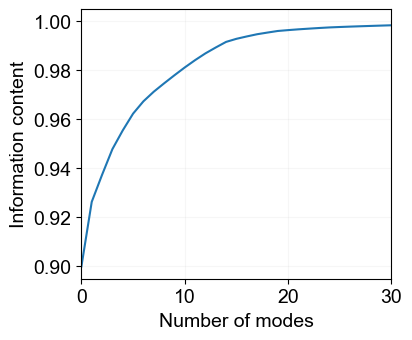

In [7]:
ric = np.cumsum(s**2) / np.sum(s**2)
plt.figure(figsize=(4, 3.5))
plt.plot(ric)
plt.xlim(0, 30)
plt.xlabel('Number of modes')
plt.ylabel('Information content')
plt.show()

This shows that the majority of the information can be recovered by a small number of modes -- this is what we want. 
We can then compute the modal coefficients for both the training and 
testing datasets.

In [8]:
a_train = y_train @ u
a_test = y_test @ u

We then use radial basis function interpolation to create a interpolator
for the modal coefficients using scipy's `RBFInterpolator`. We then evaluate
the `RBFInterpolator` to obtain the predicted modal coefficients
for the testing data. Here, we use the default parameters for the RBF
(i.e., the thin plane spline kernel and zero smoothing applied).

In [9]:
rbf = RBFInterpolator(X_train, a_train)
a_pred = rbf(X_test)

Let's look at how well the modal coefficients are predicted for the 1st mode.

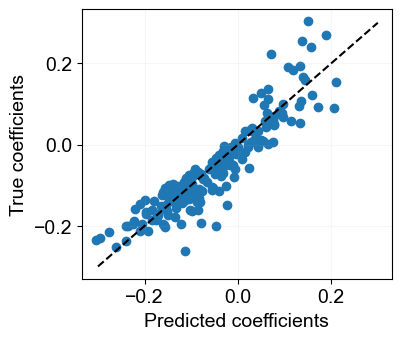

In [10]:
plt.figure(figsize=(4, 3.5))
plt.scatter(a_pred.T[1], a_test.T[1])
plt.plot([-0.3, 0.3], [-0.3, 0.3], c='k', ls='--')
plt.xlabel('Predicted coefficients')
plt.ylabel('True coefficients')
plt.show()

We see that the true cofficients are generally recovered well, though there is not perfect agreement.
We can now use all the predicted modal coefficients to create PGV maps
by performing weighted sums of the modes.

In [11]:
y_pred = a_pred @ u.T

We will then compute the errors as the difference between the
ROM predictions and the simulations in the testing dataset.

In [12]:
errs = y_test - y_pred

Finally, we look at an example of a PGV map from the testing dataset, 
and see how well it is predicted by the ROM.

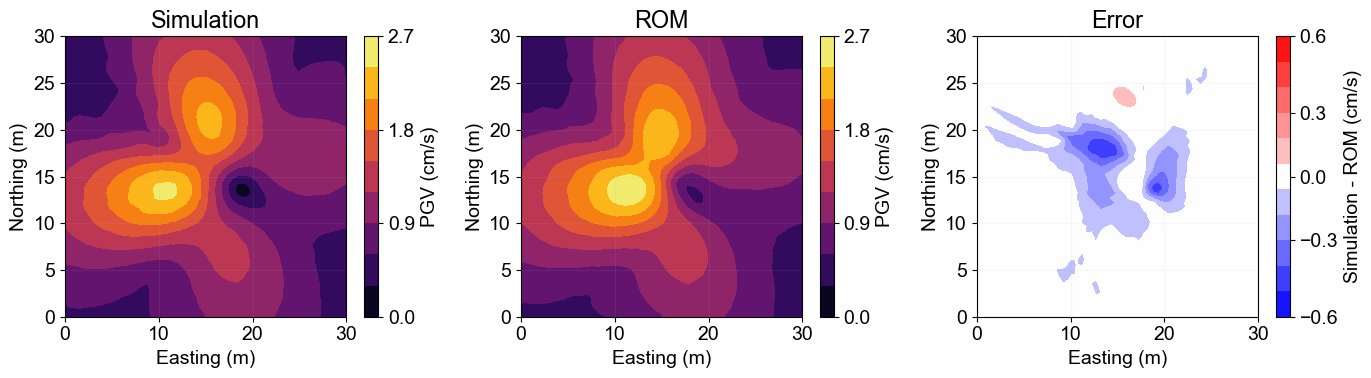

In [13]:
idx = 10
data = [y_test, y_pred, errs]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
levels = np.linspace(0, 4.5, 10)
cmaps = ['inferno', 'inferno', 'bwr']
titles = ['Simulation', 'ROM', 'Error']
for i, ax in enumerate(axes):
    if i == 2:
        levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        ticks = [-0.6, -0.3, 0, 0.3, 0.6]
        clabel = 'Simulation - ROM (cm/s)'
    else:
        levels = np.linspace(0, 2.7, 10)
        ticks = np.linspace(0, 2.7, 4)
        clabel = 'PGV (cm/s)'
    im = ax.contourf(X, Y, 100 * data[i][idx].reshape(60, 60).T, cmap=cmaps[i], levels=levels)
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_title(titles[i])
    cbar = plt.colorbar(im, ax=ax, label=clabel)
    cbar.set_ticks(ticks)
plt.tight_layout()
plt.show()